# Master Quantum Mitigation Experiments
This notebook uses `backend_utils.py` and `mitiq_utils.py` to run and compare ZNE, PEC, and LRE across circuit depths.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from backend_utils_updated_3 import get_backend, get_circuit
from backend_utils_4 import execute as full_execute

from mitiq_utils_2 import run_experiment, test_depths, plot_heatmap


In [ ]:
# Experiment parameters
circuit_type = "mirror"        # Benchmark: 'rb', 'mirror', 'ghz', 'long cnot'
n_qubits = 3                   # Number of logical qubits
depths = list(range(1, 11, 2)) # Depths from 1 to 9, step 2
seeds = list(range(5))         # Use seeds 0-4 for averaging

backend_name = "FakeTorino"
use_ideal = False              # Use noisy simulator
shots = 10_000                 # Shots per circuit
scale_factors = [1.0, 2.0, 3.0]# ZNE scale factors
pec_samples = 100              # PEC number of samples
lre_degree = 1                 # LRE polynomial degree
lre_fold = 2.0                 # LRE fold multiplier


Could not plot FakeProviderForBackendV2: 'FakeProviderForBackendV2' object has no attribute 'configuration'


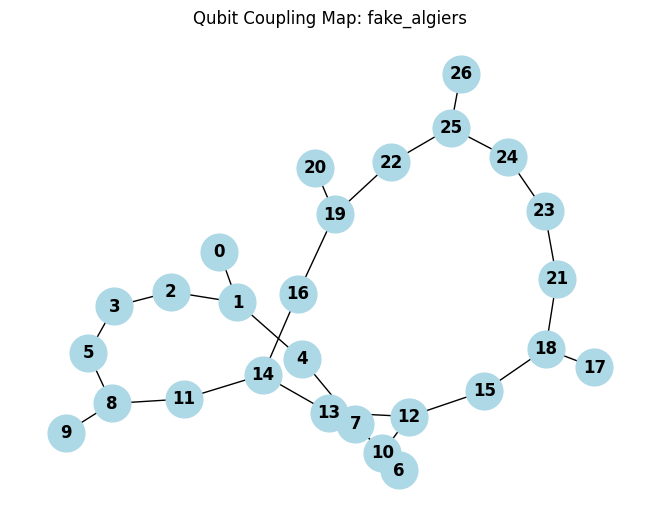

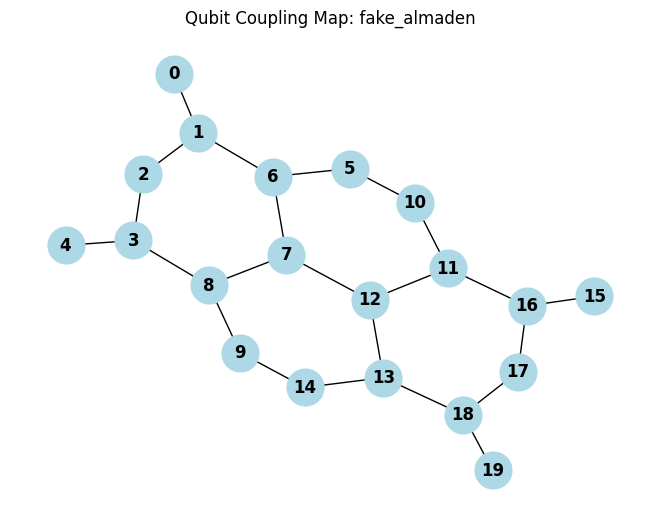

Could not plot FakeArmonkV2: 'NoneType' object is not iterable


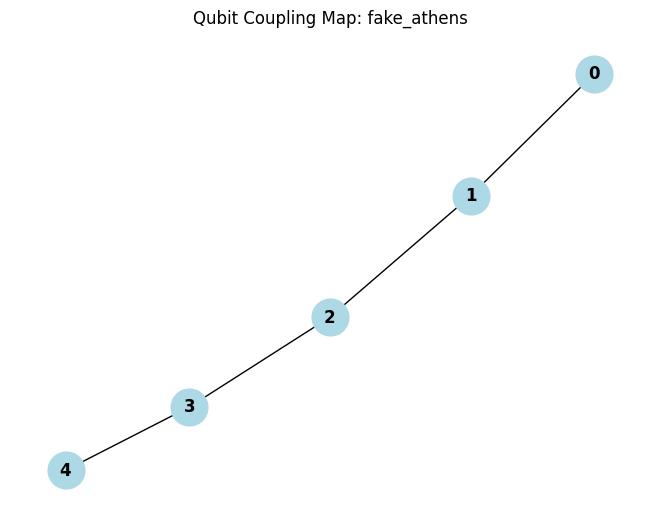

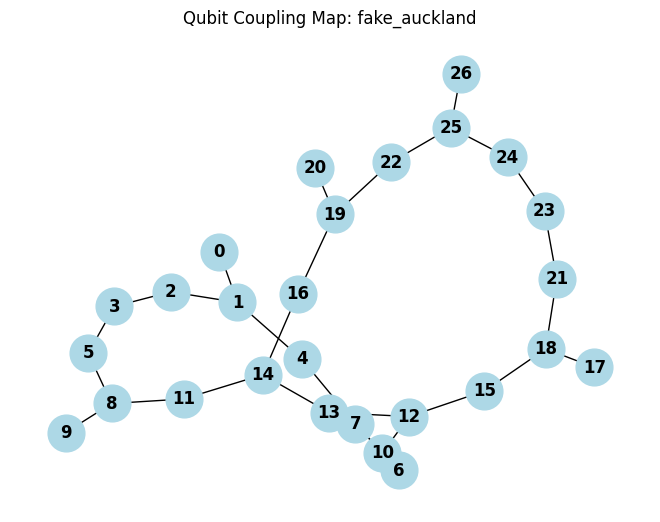

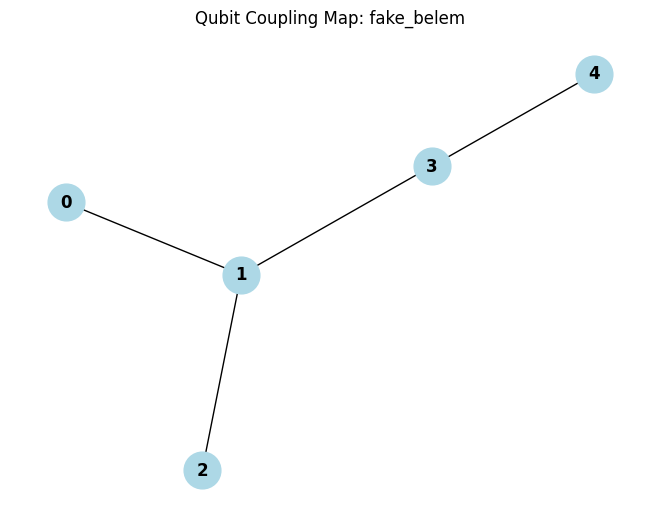

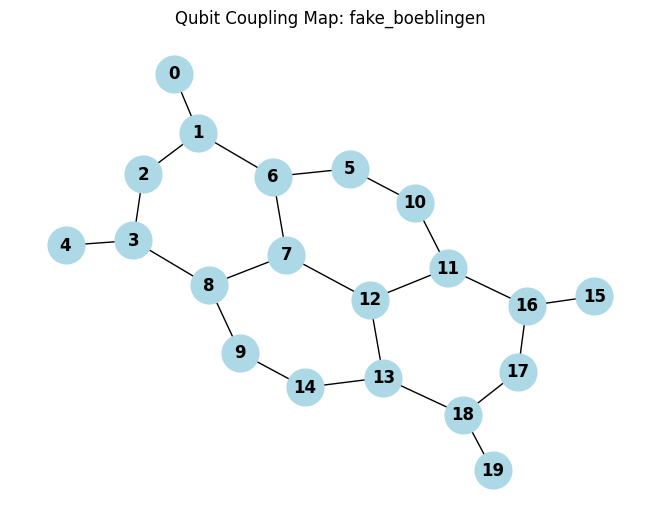

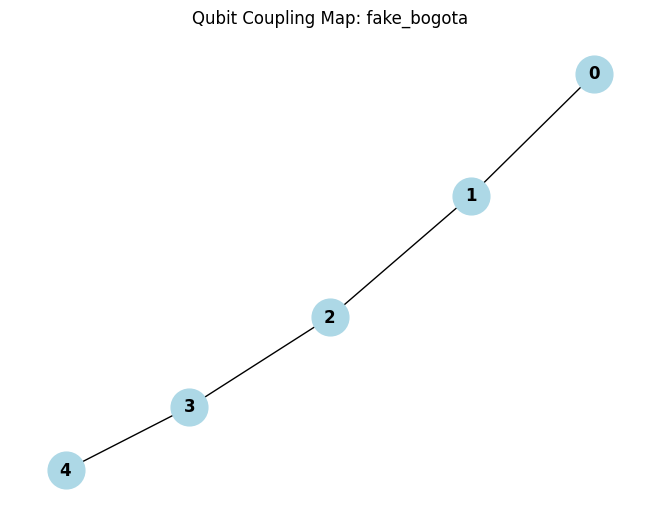

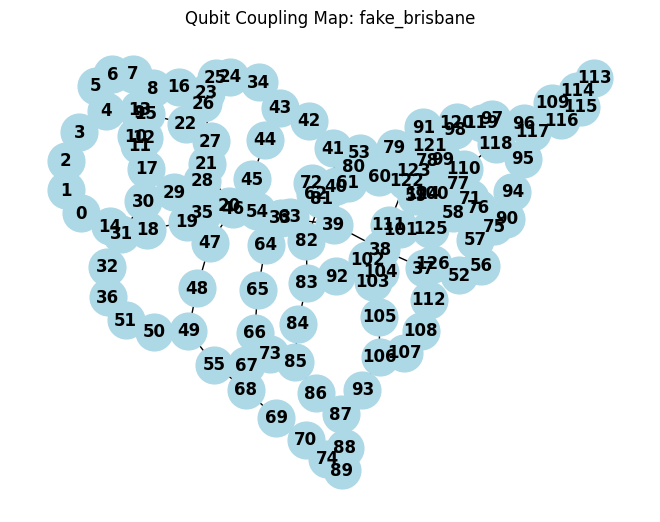

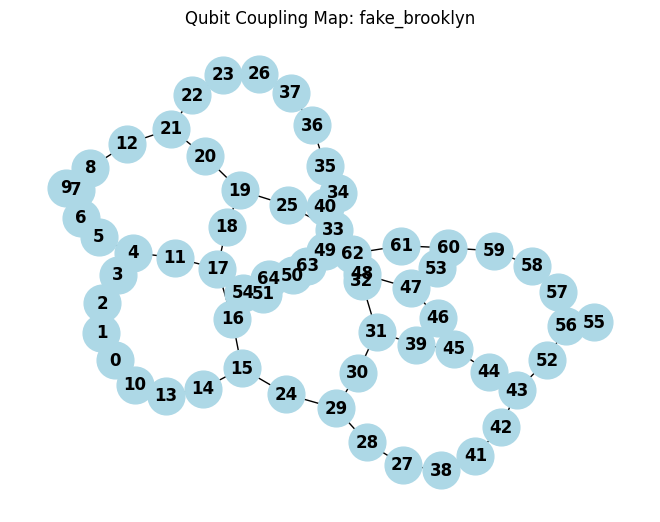

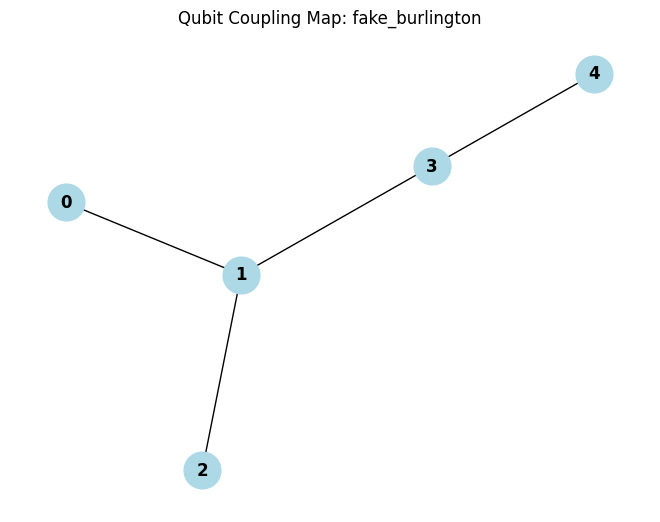

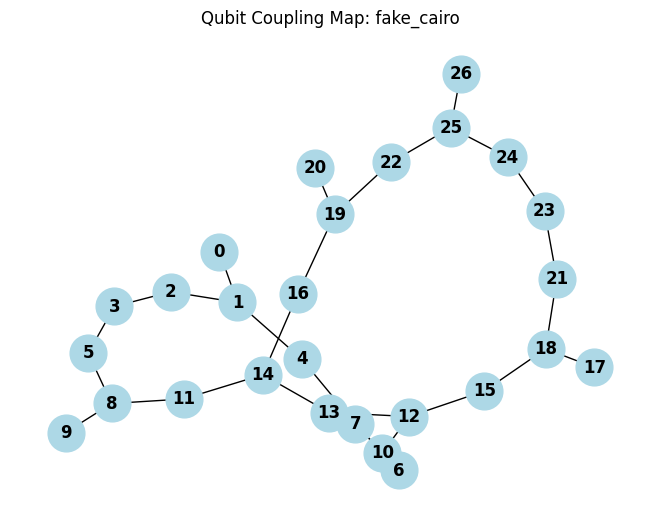

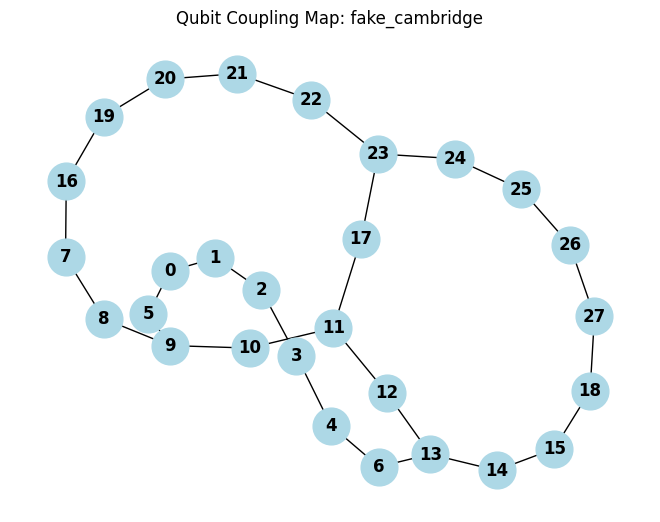

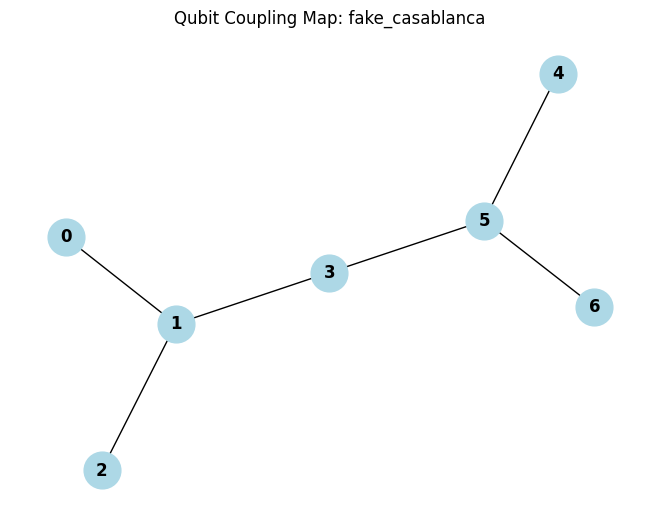

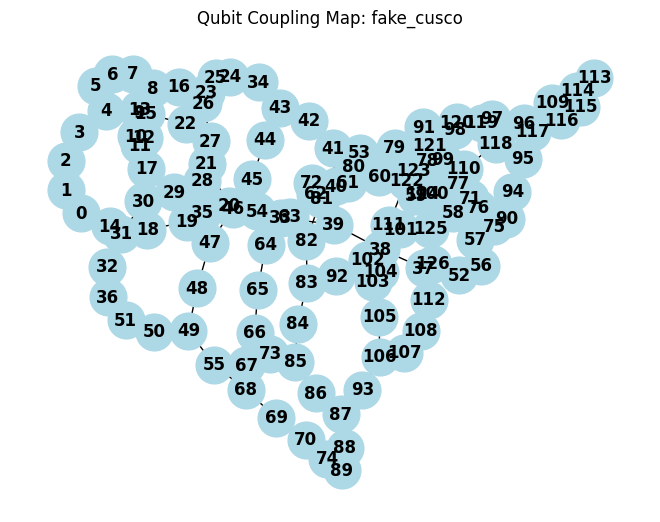

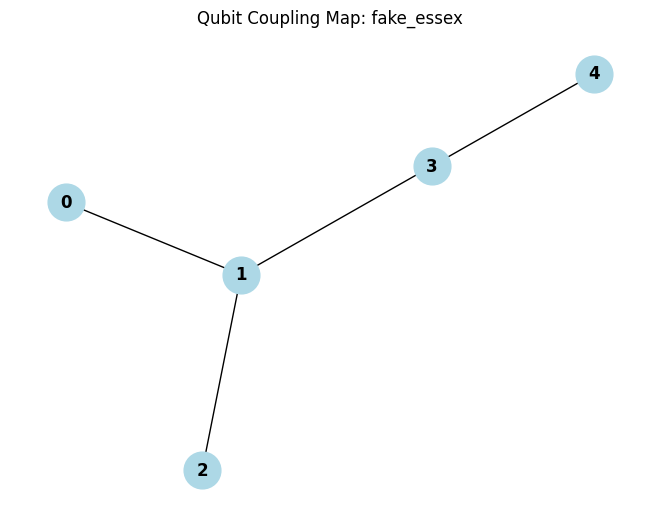

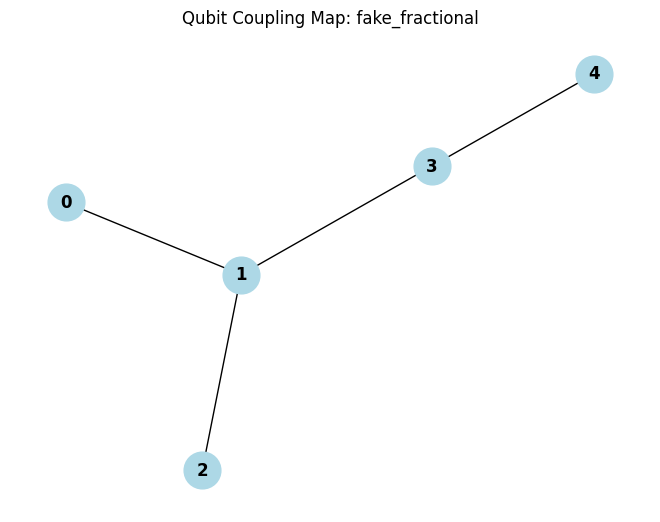

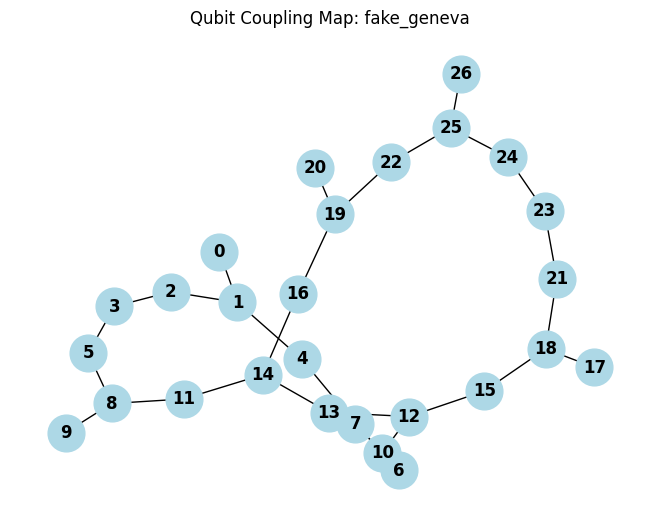

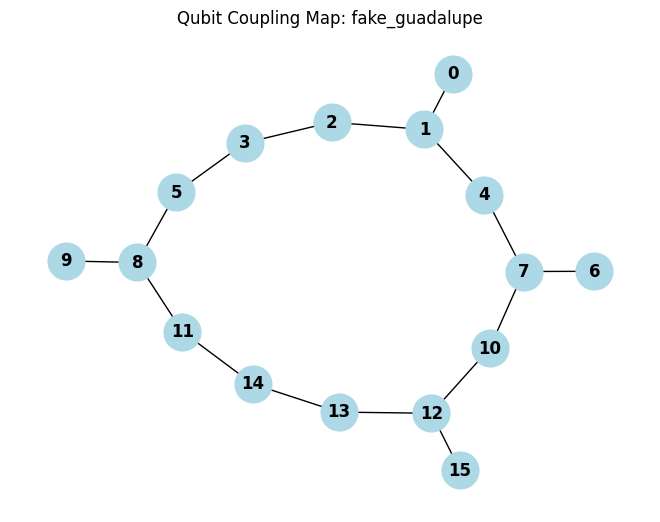

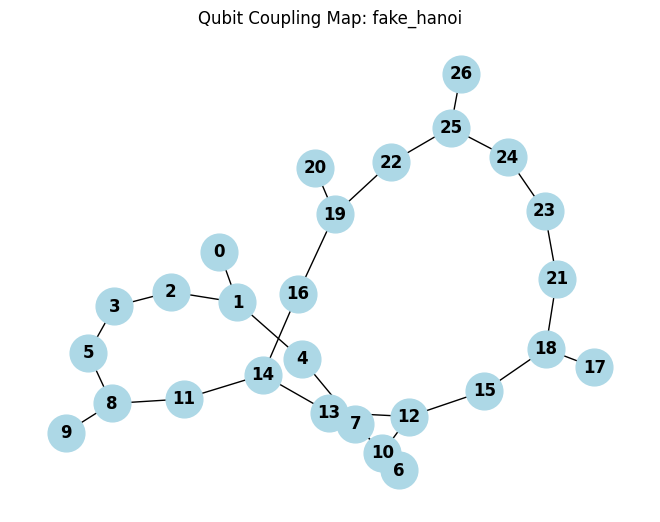

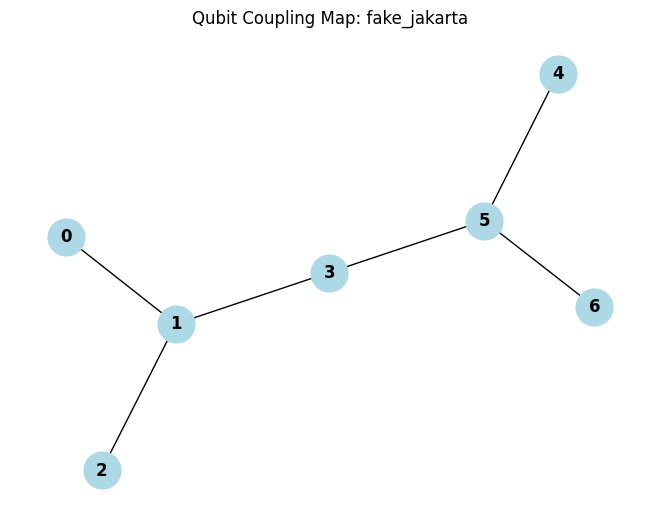

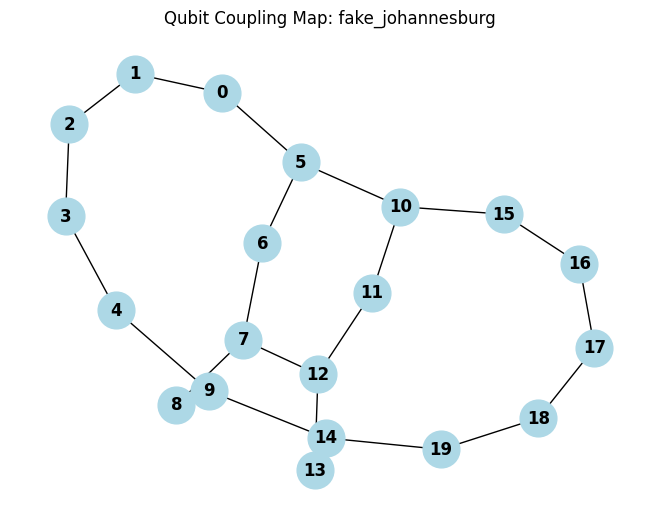

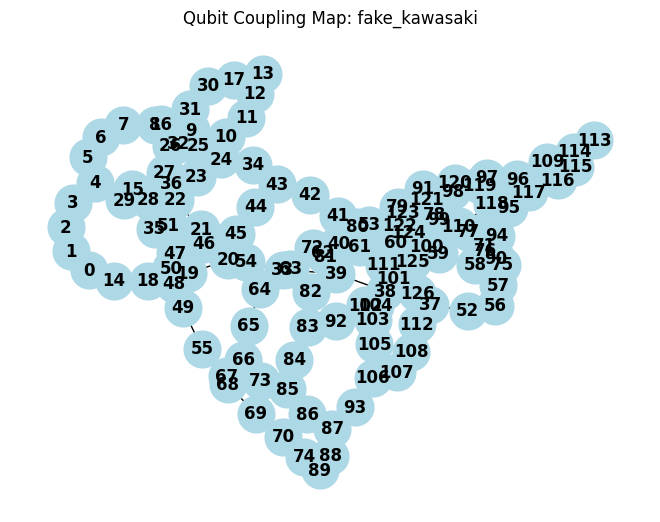

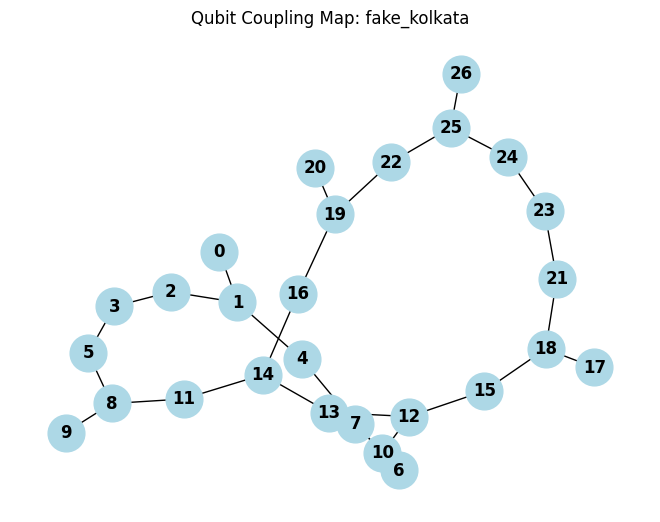

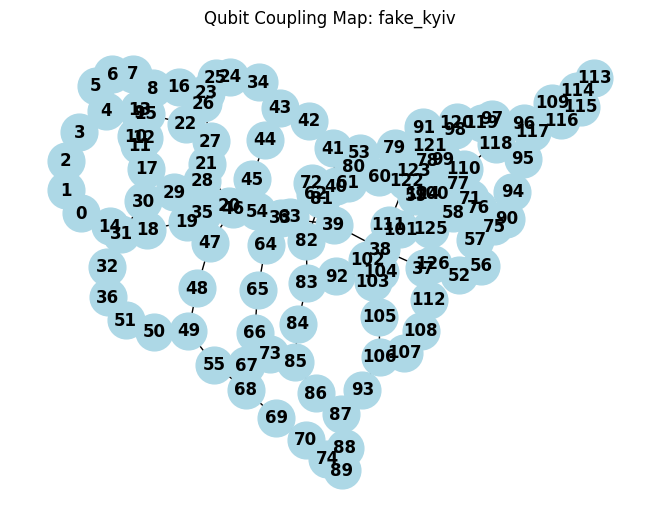

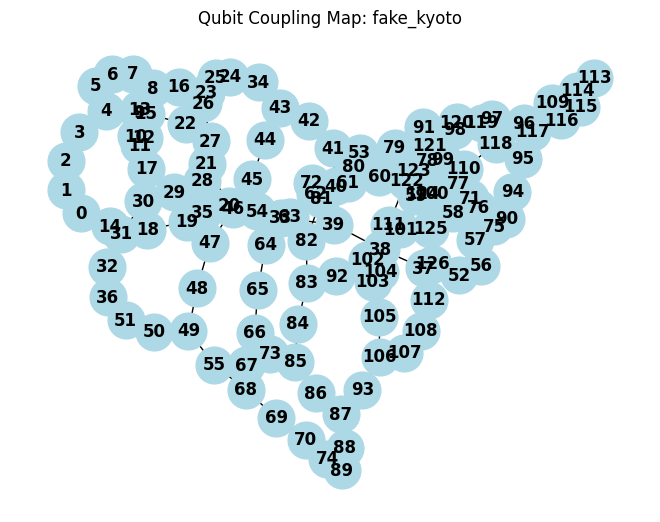

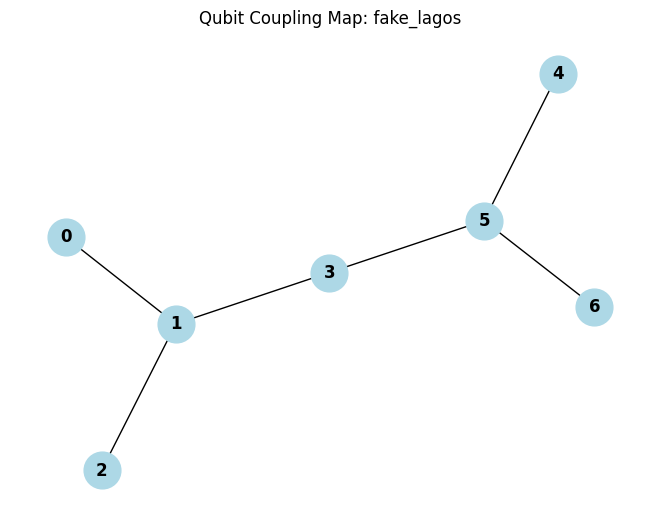

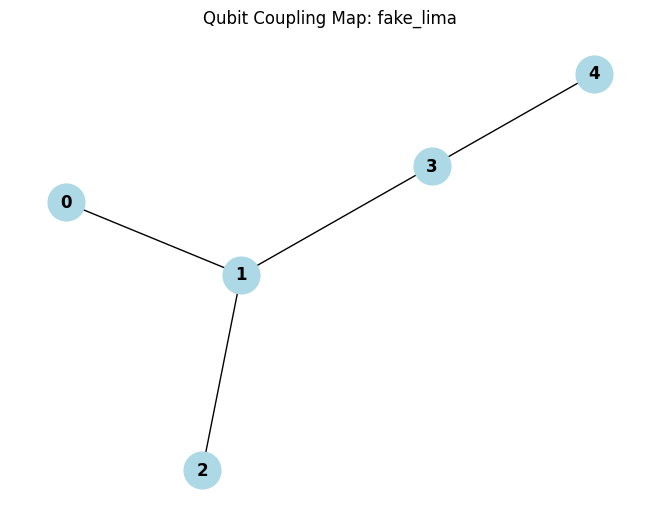

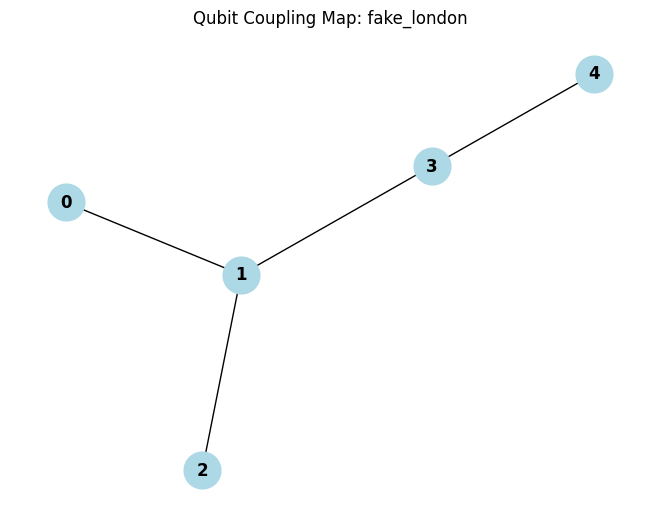

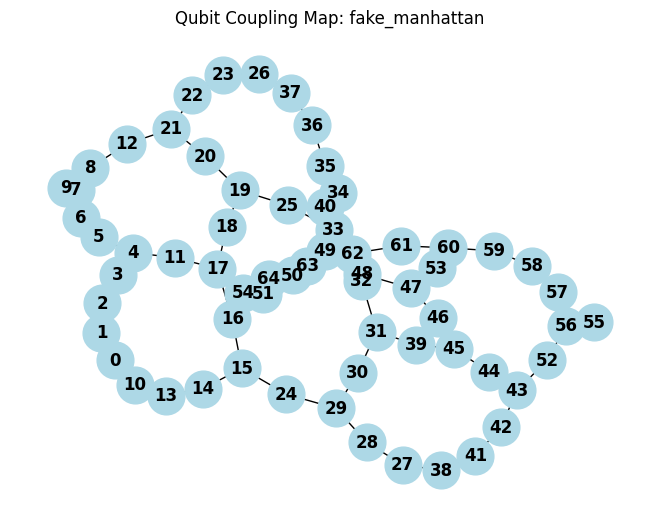

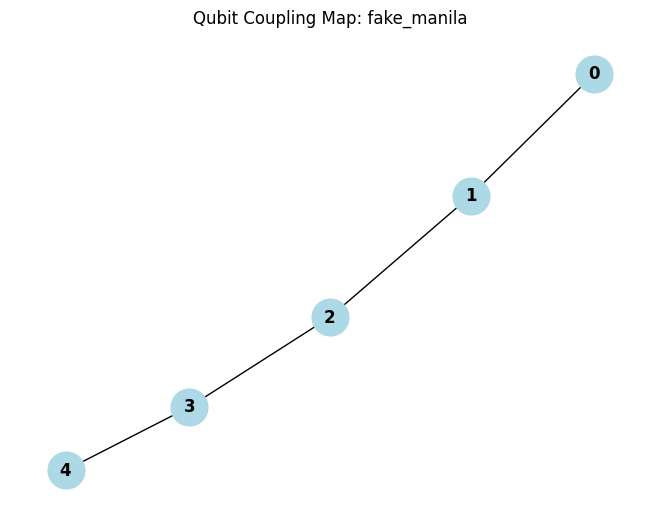

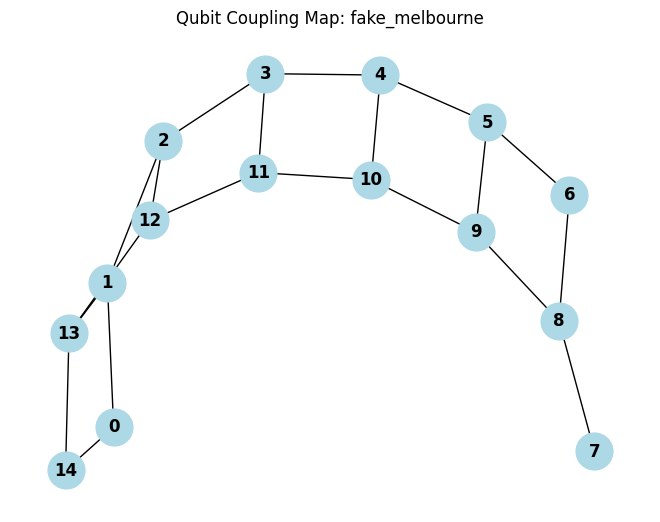

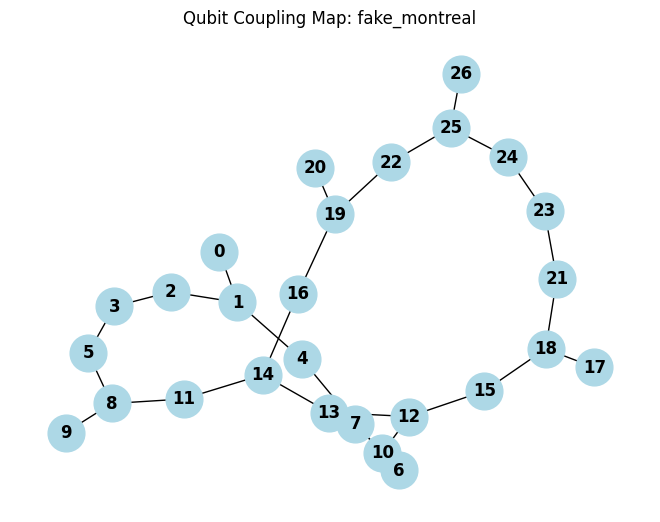

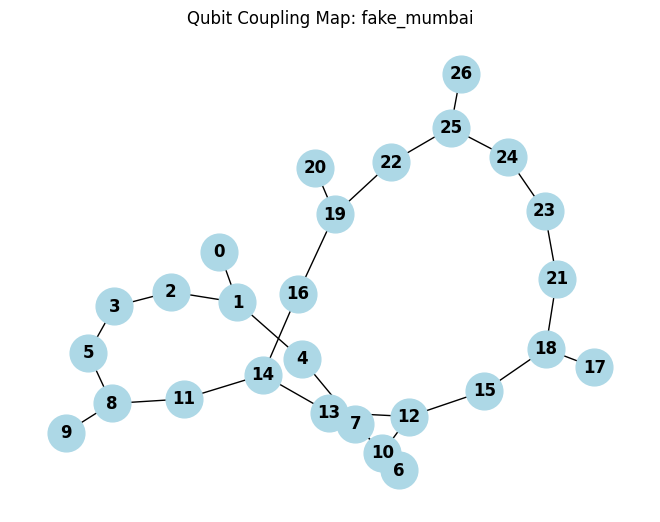

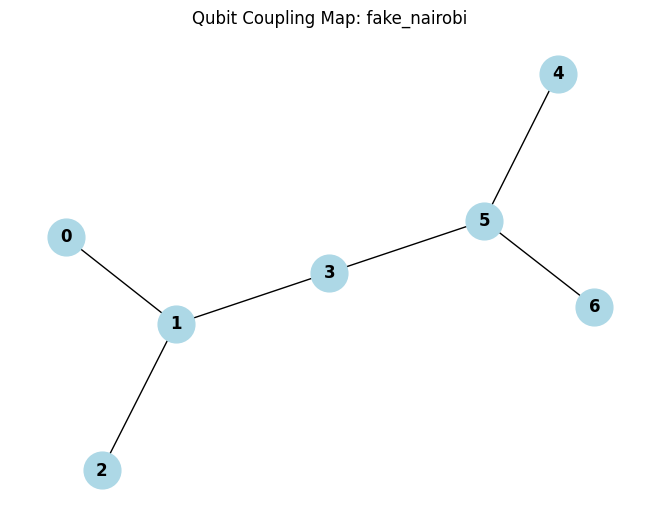

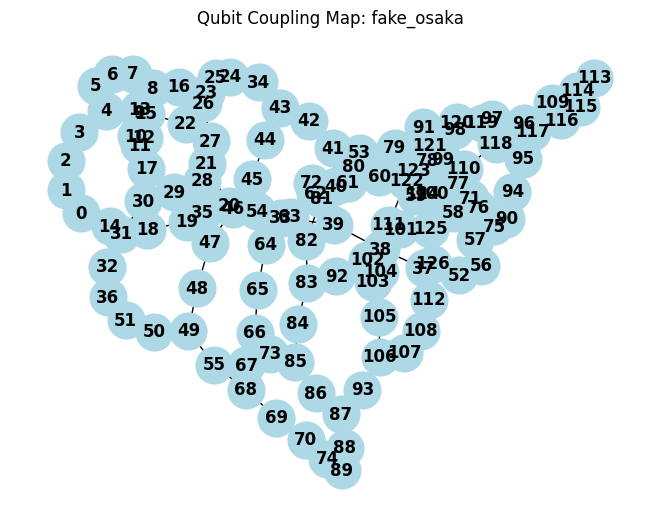

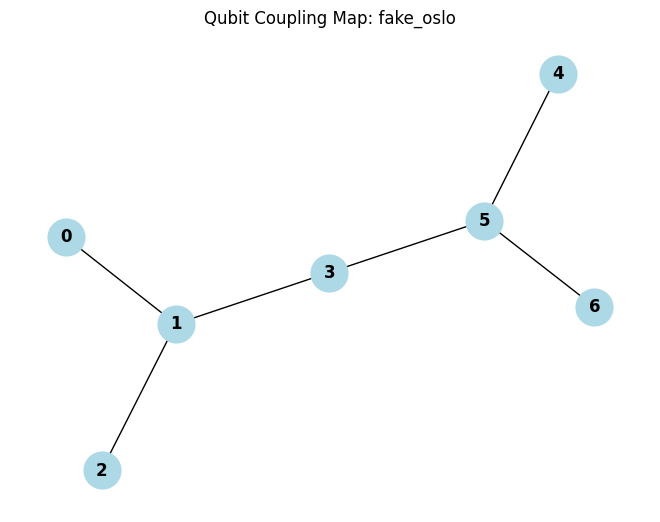

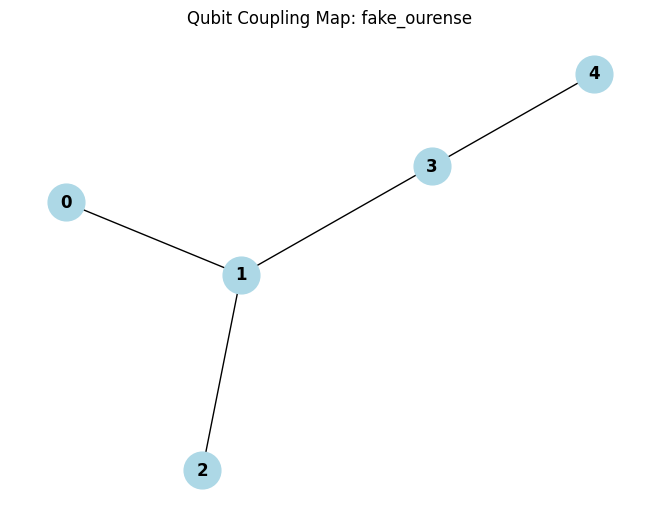

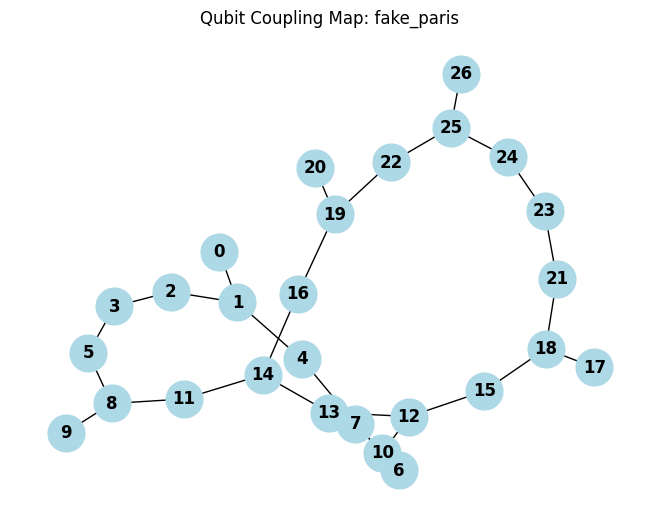

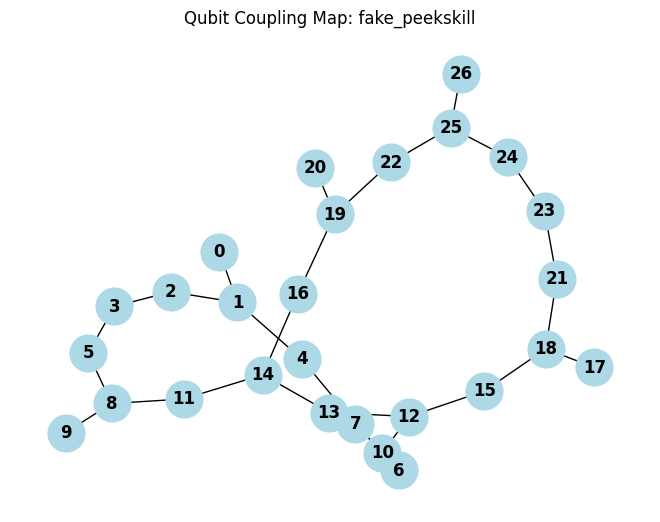

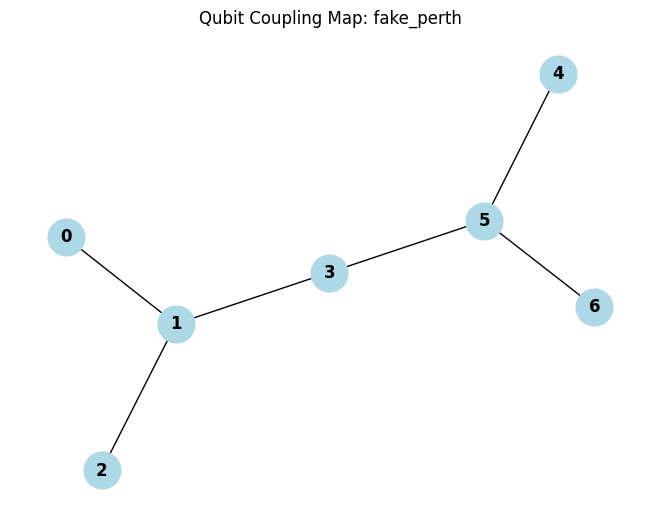

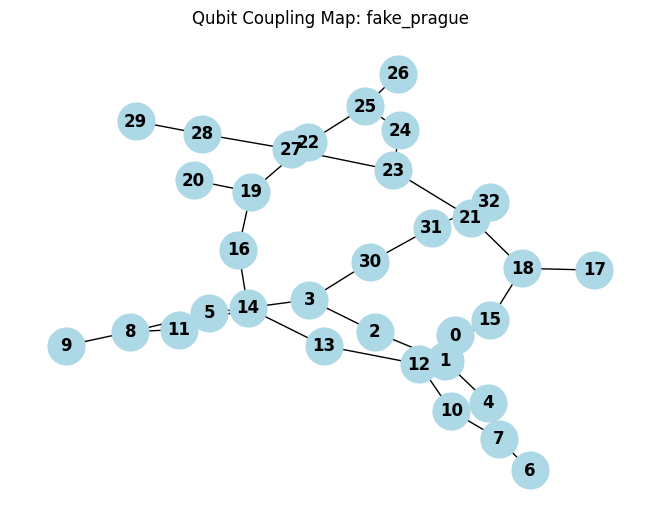

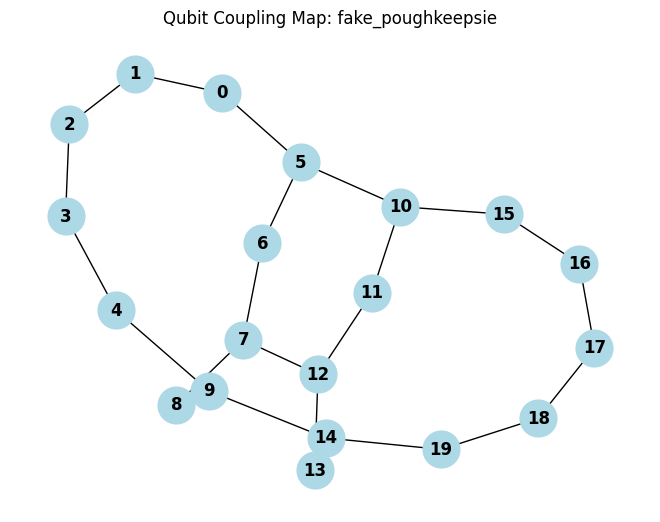

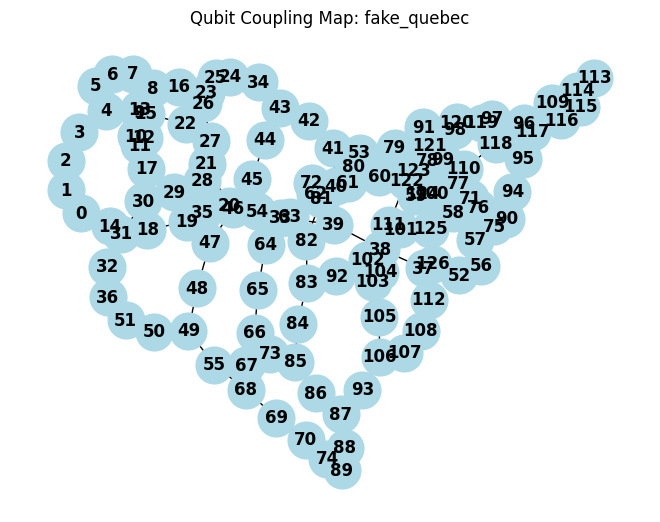

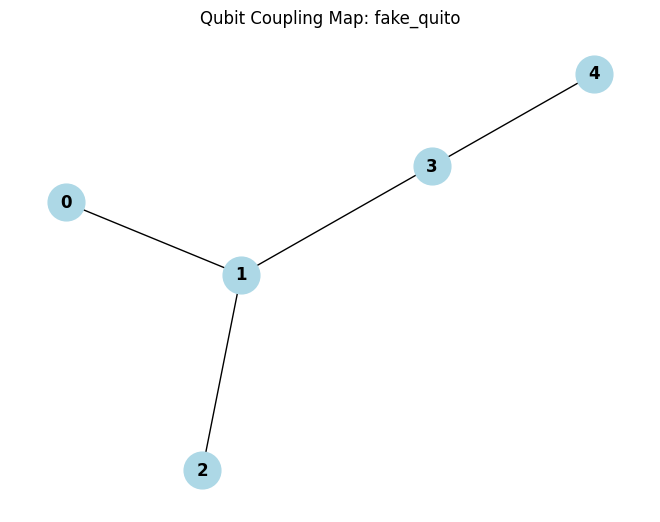

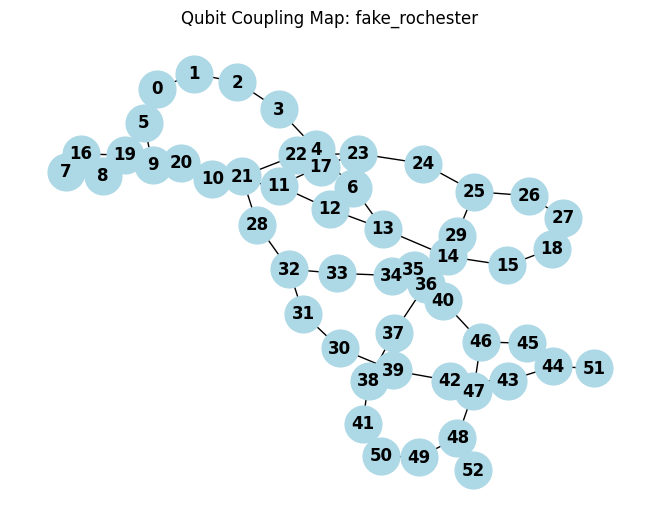

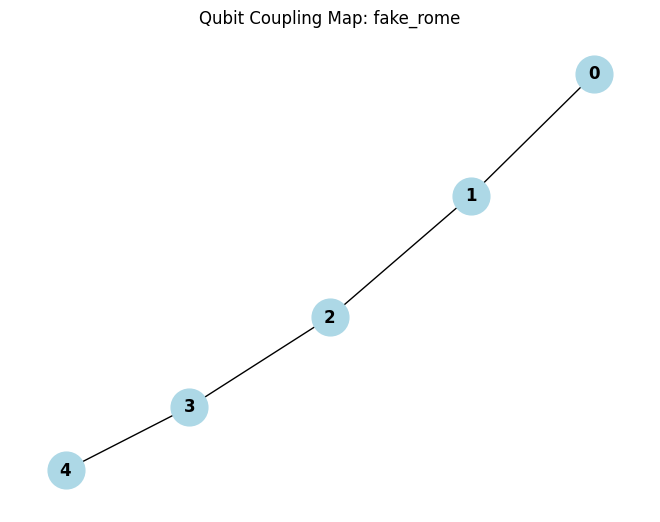

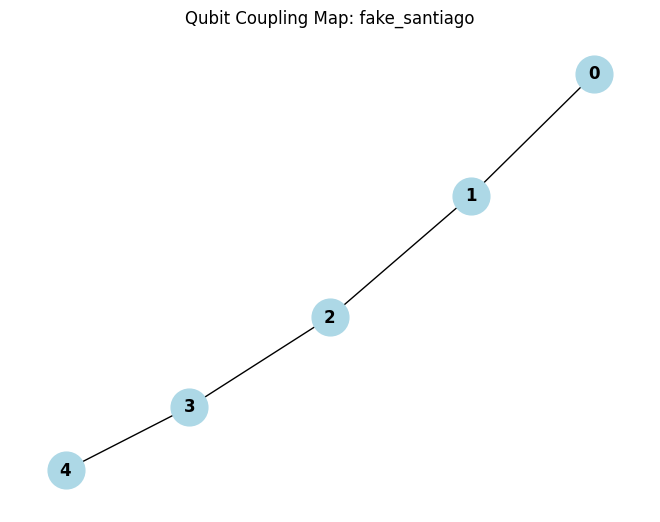

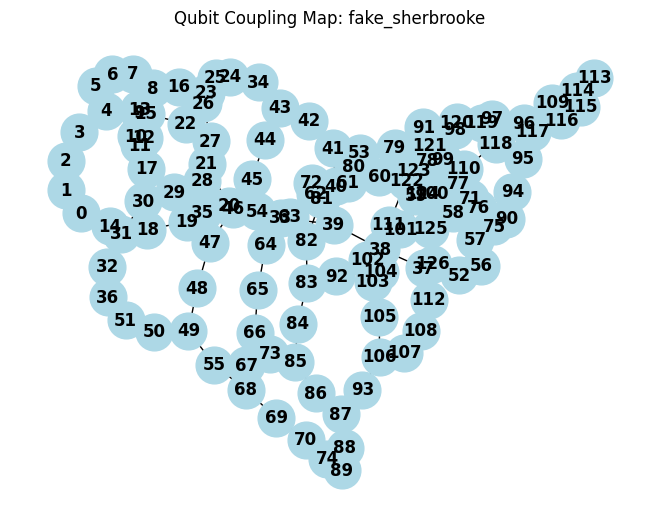

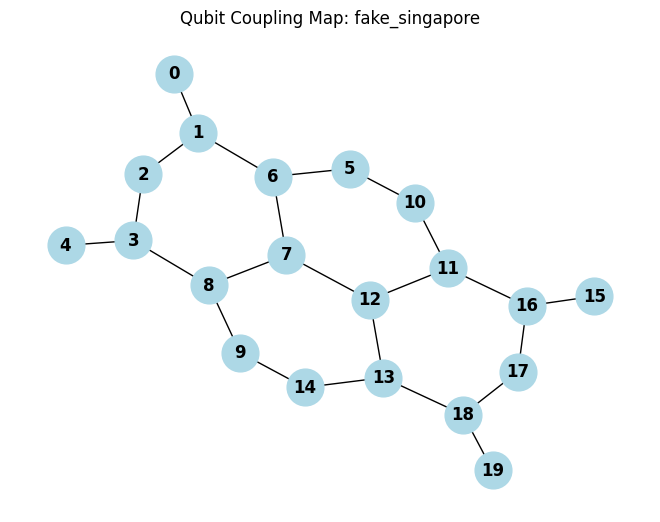

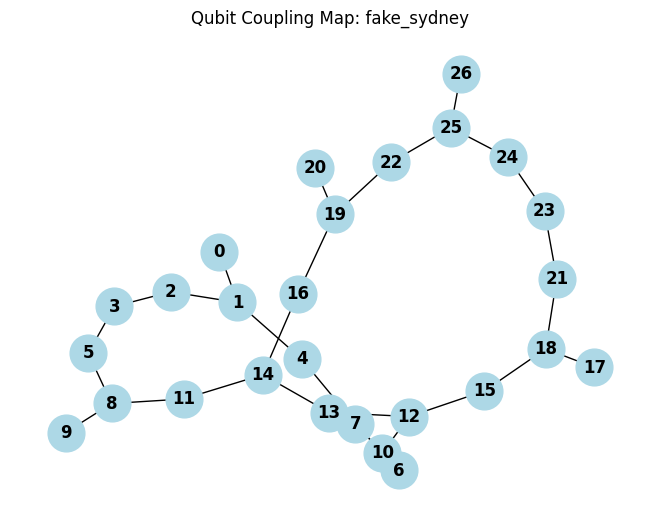

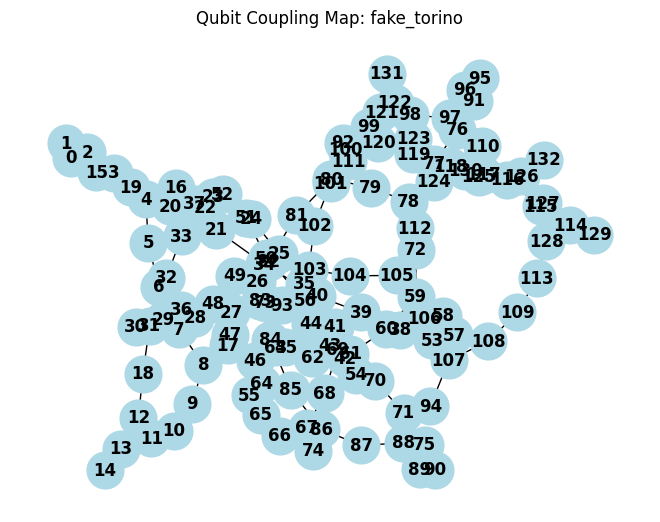

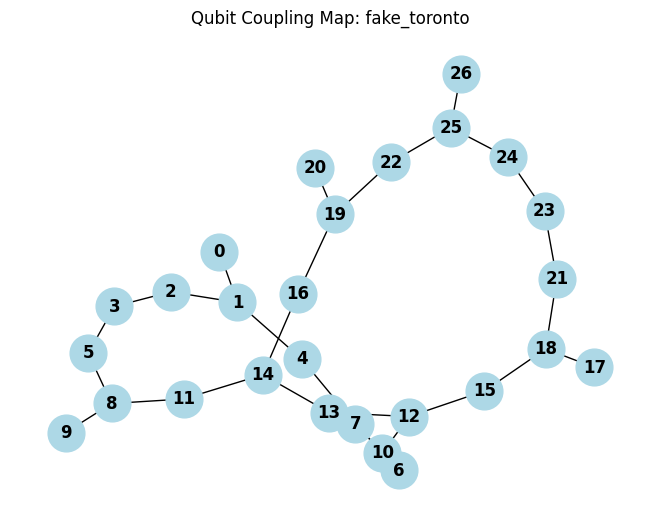

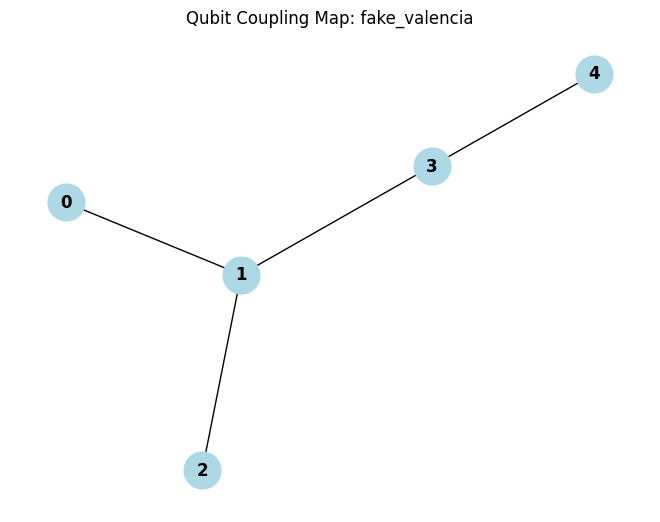

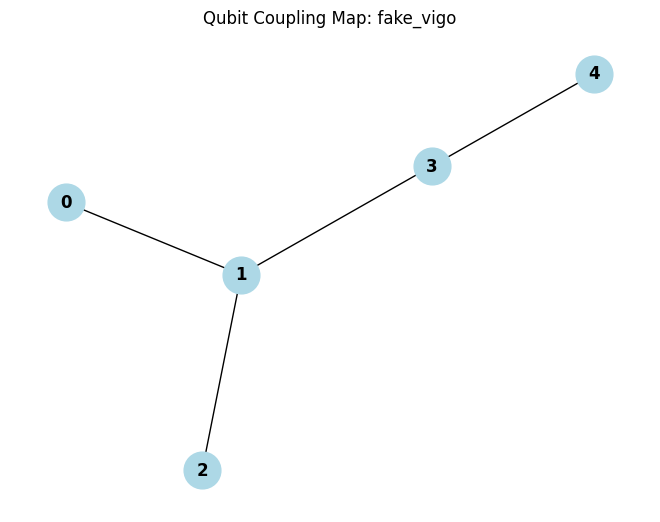

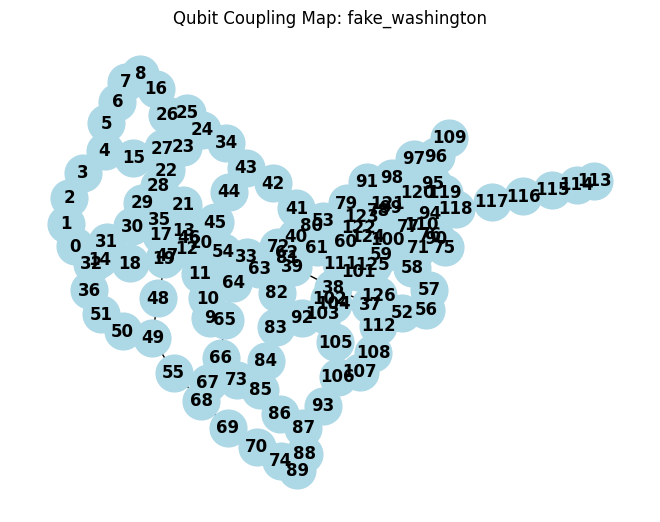

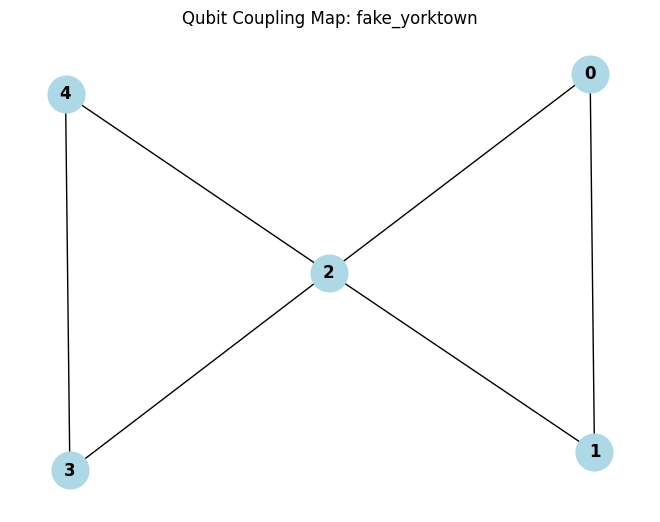

In [15]:
import networkx as nx
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import (
    FakeJakartaV2,
    FakeLimaV2,
    FakeKolkataV2
)
from qiskit.providers.fake_provider import GenericBackendV2
import qiskit
from typing import List, Tuple
from mitiq.benchmarks import generate_rb_circuits, generate_mirror_circuit, generate_ghz_circuit
import networkx as nx
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import fake_provider as ibm_fake

# Collect all fake backend classes from qiskit_ibm_runtime.fake_provider
fake_backends = [
    cls for name, cls in vars(ibm_fake).items()
    if isinstance(cls, type) and name.startswith("Fake")
]

# Define a function to plot the qubit coupling map
def plot_backend_graph(backend_class):
    try:
        backend = backend_class()
        cmap = backend.configuration().coupling_map
        n_qubits = backend.configuration().num_qubits

        G = nx.Graph()
        G.add_nodes_from(range(n_qubits))
        G.add_edges_from(cmap)

        pos = nx.spring_layout(G, seed=42)
        nx.draw(
            G, pos, with_labels=True, node_color="lightblue",
            node_size=700, font_weight="bold"
        )
        plt.title(f"Qubit Coupling Map: {backend.name}")
        plt.show()
    except Exception as e:
        print(f"Could not plot {backend_class.__name__}: {e}")

# Try plotting all fake backends
for cls in fake_backends:
    plot_backend_graph(cls)

# Supported fake devices (excluding unsupported runtime-only fakes)
FAKE_DEVICES = {
    "FakeJakartaV2": FakeJakartaV2,
    "FakeLimaV2": FakeLimaV2,
    "FakeKolkataV2": FakeKolkataV2,
    
    "Generic": GenericBackendV2,
}

# Optional device layouts for physical qubit mapping
DEVICE_LAYOUTS = {
    "FakeLimaV2": [0, 1, 3, 4, 2],
    "FakeKolkataV2": [
        0, 1, 4, 7, 10, 12, 15, 18, 21, 23, 24, 25,
        22, 19, 16, 14, 11, 8, 5, 3, 2
    ],
    # Add more layouts from qiskit.providers.fake_provider as needed
}

def get_backend(use_ideal: bool = True,
                backend_name: str = "FakeJakartaV2",
                n_qubits: int = 5):
    """
    Returns a backend for running circuits.

    Args:
        use_ideal (bool): If True, returns an ideal AerSimulator.
        backend_name (str): Fake backend name if use_ideal=False.
        n_qubits (int): Only used for GenericBackendV2.

    Returns:
        Qiskit Backend instance.
    """
    if use_ideal:
        return AerSimulator()

    if backend_name not in FAKE_DEVICES:
        raise ValueError(f"Unsupported backend name: {backend_name}")

    backend_class = FAKE_DEVICES[backend_name]
    return backend_class(n_qubits) if backend_name == "Generic" else backend_class()

def full_execute(
    circuits: qiskit.QuantumCircuit | list[qiskit.QuantumCircuit],
    backend,
    shots: int,
    correct_bitstring: str,
    verbose: bool,
    ) -> List[float]:
    """Executes the input circuit(s) and returns ⟨A⟩, where A = |correct_bitstring⟩⟨correct_bitstring| for each circuit."""

    if not isinstance(circuits, list):
        circuits = [circuits]
    if verbose:
        # Calculate average number of CNOT gates per circuit.
        print(f"Executing {len(circuits)} circuit(s) on {backend}.")
        print(f"Average cnot count in circuits: {get_avg_cnot_count(circuits)}")

    # Store all circuits to run in list to be returned.
    to_run: list[qiskit.QuantumCircuit] = []

    for circuit in circuits:
        circuit_to_run = circuit.copy()
        circuit_to_run.measure_all()
        to_run.append(
            qiskit.transpile(
                circuit_to_run,
                backend=backend,
                initial_layout= get_phys_qubits(circuit.num_qubits),
                optimization_level=0,  # Otherwise RB circuits are simplified to empty circuits.
            )
        )

    if verbose:
        # Calculate average number of CNOT gates per compiled circuit.
        print(f"Average cnot count in compiled circuits: {get_avg_cnot_count(to_run)}")

    # Run and get counts.
    job = backend.run(
        to_run,
        # Reset qubits to ground state after each sample.
        init_qubits=True,
        shots=shots,
    )
    # IBMQ uses online queue for processing jobs.
    # if verbose and not use_noisy_simulator:
    #     time.sleep(3)
    #     while not job.in_final_state():
    #         print(f"Queue position: {job.queue_position()}")
    #         time.sleep(verbose_update_time)
    #     print()

    # print(f"Correct bitstring: {correct_bitstring}")
    if len(circuits) == 1:
        return [job.result().get_counts().get(correct_bitstring, 0.0) / shots]
    return [
        count.get(correct_bitstring, 0.0) / shots for count in job.result().get_counts()
    ]
    
def get_phys_qubits(n_qubits: int,
                    backend_name: str = "FakeLimaV2") -> List[int]:
    """
    Maps logical to physical qubit indices for a given backend layout.

    Args:
        n_qubits (int): Number of logical qubits to map.
        backend_name (str): Backend key for layout lookup.

    Returns:
        List[int]: Physical qubit indices.
    """
    layout = DEVICE_LAYOUTS.get(backend_name)
    if layout is None or n_qubits > len(layout):
        # Fallback to linear mapping
        return list(range(n_qubits))
    return layout[:n_qubits]


def get_computer_graph(n_qubits: int,
                       layout_type: str = "chain",
                       backend_name: str = None,
                       return_pattern: bool = False):
    """
    Builds a directed connectivity graph for qubits and an optional RB pattern.

    Args:
        n_qubits (int): Number of qubits.
        layout_type (str): 'chain' for linear chain or 'hardware' for physical layout.
        backend_name (str): Required if using 'hardware' layout.
        return_pattern (bool): Whether to return the RB 2-qubit pattern.

    Returns:
        networkx.DiGraph or (graph, pattern)
    """
    if layout_type == "hardware":
        if not backend_name:
            raise ValueError("Must specify backend_name for hardware layout.")
        qubits = get_phys_qubits(n_qubits, backend_name)
    else:
        qubits = list(range(n_qubits))

    graph = nx.DiGraph()
    pattern: List[List[int]] = []

    for i in range(len(qubits) - 1):
        q1, q2 = qubits[i], qubits[i + 1]
        graph.add_edge(q1, q2)
        graph.add_edge(q2, q1)
        if i % 2 == 0:
            pattern.append([q1, q2])

    if layout_type == "chain" and n_qubits % 2 == 1:
        pattern.append([qubits[-1]])

    return (graph, pattern) if return_pattern else graph


def get_circuit(circuit_type: str,
                n_qubits: int,
                depth: int,
                seed: int) -> Tuple[qiskit.QuantumCircuit, str]:
    """
    Create a benchmark circuit and return it along with the correct bitstring.

    Supports:
      - 'rb': Randomized benchmarking circuit
      - 'mirror': Mirror circuit
      - 'long cnot': Chain of CNOTs
      - 'ghz': GHZ state
    """
    typ = circuit_type.lower()
    if typ == "rb":
        circuit = generate_rb_circuits(
            n_qubits=n_qubits,
            num_cliffords=depth,
            seed=seed,
            return_type="qiskit"
        )[0]
        return circuit, "00"

    elif typ == "mirror":
        computer = get_computer_graph(n_qubits)
        circuit, correct = generate_mirror_circuit(
            nlayers=depth,
            two_qubit_gate_prob=1.0,
            connectivity_graph=computer,
            two_qubit_gate_name="CNOT",
            seed=seed,
            return_type="qiskit",
        )
        return circuit, "".join(map(str, correct[::-1]))

    elif typ == "long cnot":
        circuit = qiskit.QuantumCircuit(n_qubits)
        circuit.x(0)
        for i in range(n_qubits - 1):
            circuit.cx(i, i + 1)
        return circuit, "1" * (n_qubits - 1)

    elif typ == "ghz":
        circuit = generate_ghz_circuit(
            n_qubits=n_qubits,
            return_type="qiskit"
        )
        return circuit, "0" * n_qubits

    else:
        raise ValueError(f"Unsupported circuit type: {circuit_type}")


def get_num_cnot_count(circuit: qiskit.QuantumCircuit) -> int:
    """Return the number of CNOT gates in the circuit."""
    return circuit.count_ops().get('cx', 0)


def get_oneq_count(circuit: qiskit.QuantumCircuit) -> int:
    """Return the number of single-qubit gates in the circuit."""
    ops = circuit.count_ops()
    single = ['x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg']
    return sum(ops.get(g, 0) for g in single)


def get_avg_cnot_count(circuits: List[qiskit.QuantumCircuit]) -> float:
    """Average CNOT count over a list of circuits."""
    return sum(get_num_cnot_count(c) for c in circuits) / max(len(circuits), 1)


In [6]:
# Define executor function returning expectation of |0...0>
def executor(circuit, backend):
    qc = circuit.copy()
    qc.measure_all()
    transpiled = qiskit.transpile(qc, backend=backend, optimization_level=0)
    job = backend.run(transpiled, shots=shots)
    counts = job.result().get_counts()
    key = '0' * circuit.num_qubits
    return counts.get(key, 0) / shots


In [13]:
from functools import partial
executor = partial(
    full_execute,
    shots=shots,
    correct_bitstring="0"*n_qubits,
    verbose=False
)


In [14]:
# Run depth sweeps for each mitigation method
methods = ['zne', 'pec', 'lre']
results = {}
for method in methods:
    results[method] = test_depths(
        method=method,
        executor=executor,
        circuit_type=circuit_type,
        n_qubits=n_qubits,
        depths=depths,
        seeds=seeds,
        backend_name=backend_name,
        use_ideal=use_ideal,
        scale_factors=scale_factors,
        pec_num_samples=pec_samples,
        lre_degree=lre_degree,
        lre_fold=lre_fold,
        random_state=42
    )
results


c:\Users\Roy\Phys522\.venv\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X^-0.5───.
  warnings.warn(
c:\Users\Roy\Phys522\.venv\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\Roy\Phys522\.venv\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_2: ───Ry(-0.5π)───.
  warnings.warn(
c:\Users\Roy\Phys522\.venv\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_0: ───X───.
  warnings.warn(
c:\Users\Roy\Phys522\.venv\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_1: ───X^0.5───.
  warnings.warn(
c:\Users\Roy\Phys522\.venv\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representation found for 

q_2: ───X^-0.5───.
  warnings.warn(
c:\Users\Roy\Phys522\.venv\Lib\site-packages\mitiq\pec\sampling.py:75: UserWarning: No representatio

KeyboardInterrupt: 

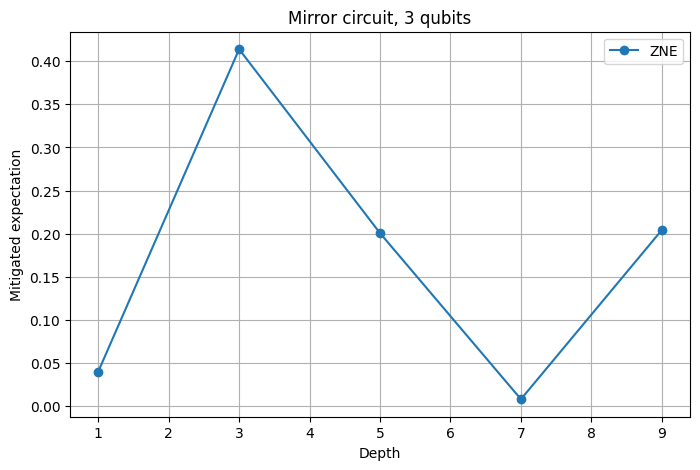

In [16]:
# Plot average mitigated expectation vs depth
plt.figure(figsize=(8,5))
for method, res in results.items():
    plt.plot(depths, [res[d] for d in depths], marker='o', label=method.upper())
plt.title(f"{circuit_type.capitalize()} circuit, {n_qubits} qubits")
plt.xlabel("Depth")
plt.ylabel("Mitigated expectation")
plt.legend()
plt.grid(True)


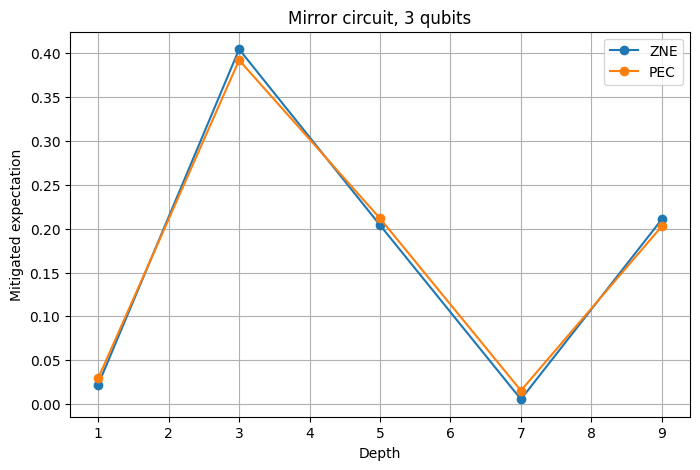

In [ ]:
# Plot average mitigated expectation vs depth
plt.figure(figsize=(8,5))
for method, res in results.items():
    plt.plot(depths, [res[d] for d in depths], marker='o', label=method.upper())
plt.title(f"{circuit_type.capitalize()} circuit, {n_qubits} qubits")
plt.xlabel("Depth")
plt.ylabel("Mitigated expectation")
plt.legend()
plt.grid(True)


## Example Heatmap: Raw values for ZNE
Below is how you could heatmap depth vs seed expectation values (add more methods as needed).

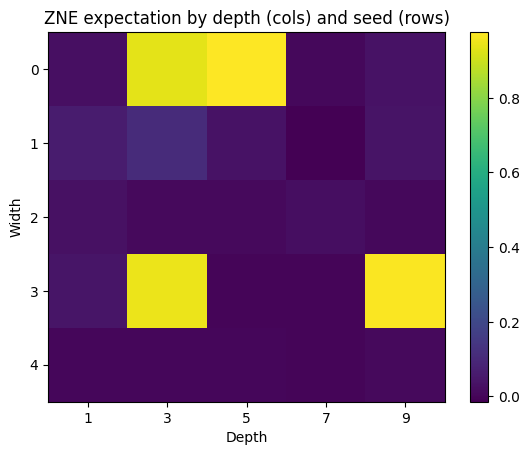

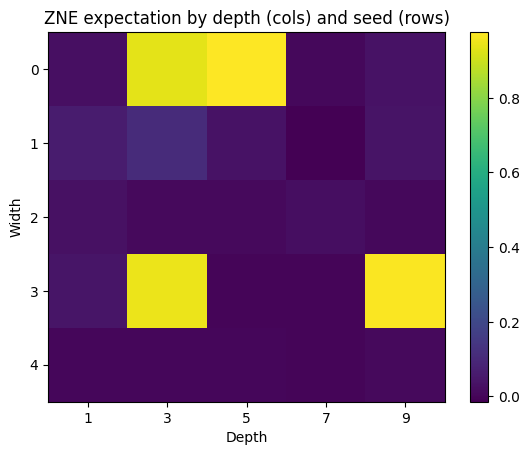

In [17]:
# Prepare matrix for ZNE: rows=seeds, cols=depths
from mitiq_utils_2 import test_depths
zne_matrix = np.array([
    [run_experiment(
        method='zne',
        executor=executor,
        circuit_type=circuit_type,
        n_qubits=n_qubits,
        depth=d,
        seed=s,
        backend_name=backend_name,
        use_ideal=use_ideal,
        scale_factors=scale_factors,
        random_state=s
    ) for d in depths]
    for s in seeds
])
fig = plot_heatmap(zne_matrix, depths, seeds, "ZNE expectation by depth (cols) and seed (rows)")
fig



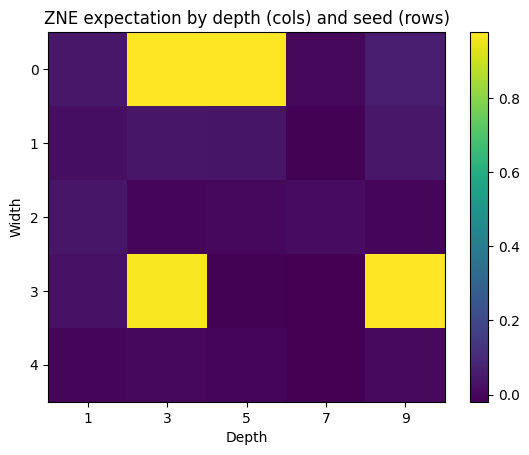

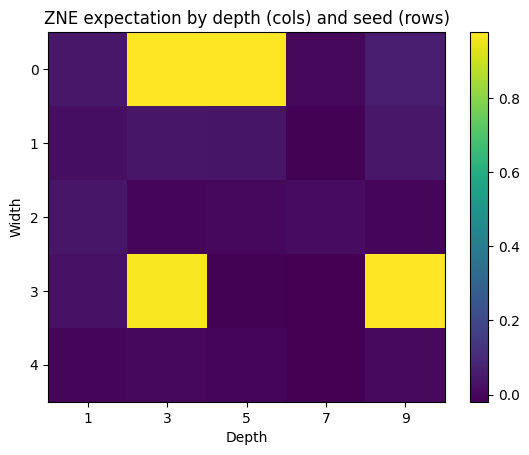

In [ ]:
# Prepare matrix for ZNE: rows=seeds, cols=depths
from mitiq_utils_2 import test_depths
zne_matrix = np.array([
    [run_experiment(
        method='zne',
        executor=executor,
        circuit_type=circuit_type,
        n_qubits=n_qubits,
        depth=d,
        seed=s,
        backend_name=backend_name,
        use_ideal=use_ideal,
        scale_factors=scale_factors,
        random_state=s
    ) for d in depths]
    for s in seeds
])
fig = plot_heatmap(zne_matrix, depths, seeds, "ZNE expectation by depth (cols) and seed (rows)")
fig
